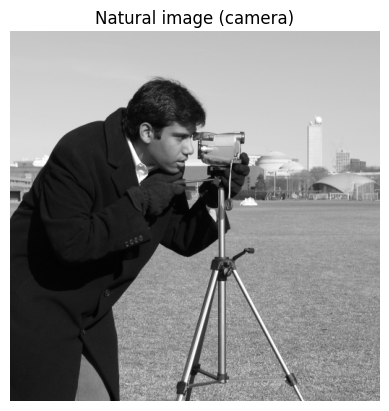

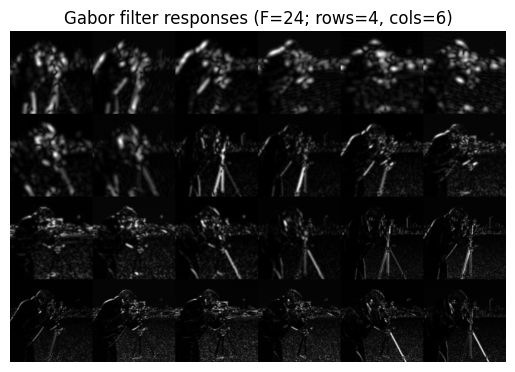

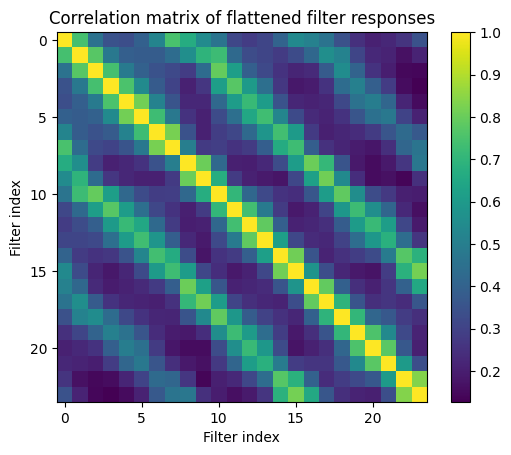

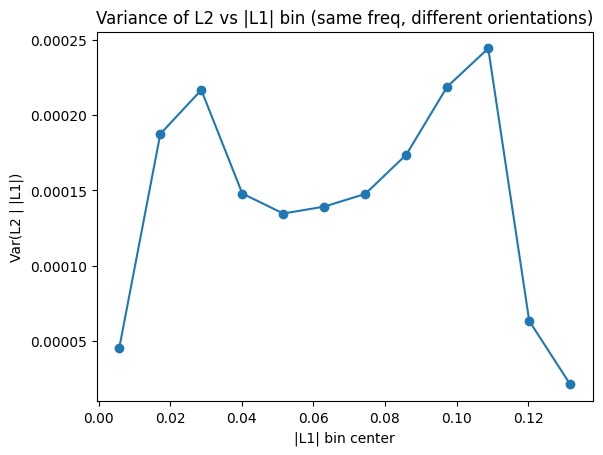

Chosen filter indices for conditional variance demo:
L1 index: 8 params: (0.1, np.float64(0.0))
L2 index: 10 params: (0.1, np.float64(0.7853981633974483))
Pearson corr(L1, L2): 0.42327324591135496


In [4]:
# Let's build a small demo that:
# 1) Loads a natural image (grayscale).
# 2) Builds a skimage Gabor filter bank (several frequencies and orientations).
# 3) Convolves the image with each filter to get response maps (use the magnitude).
# 4) Creates a single mosaic image showing all responses (no subplots).
# 5) Computes a correlation matrix between flattened responses and plots it.
# 6) Demonstrates conditional variance: Var(L2 | |L1| bin) increases with |L1|.
#
# Notes per tool rules:
# - Use matplotlib (no seaborn), one chart per figure, no custom colors/styles.
# - Use a single mosaic image to avoid subplots for the filter responses.
# - Additional figures: original image, correlation heatmap, conditional-variance curve.

import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.color import rgb2gray
from skimage.filters import gabor
from itertools import product

# 1) Load a natural image
img = data.camera()  # already grayscale uint8
img = img_as_float(img)

# 2) Build Gabor filter bank parameters (skimage.filters.gabor computes convolution directly)
#    We'll vary frequency (scales) and theta (orientations).
frequencies = [0.05, 0.1, 0.2]        # cycles per pixel (lower => larger scale)
orientations = np.linspace(0, np.pi, 8, endpoint=False)
bank = list(product(frequencies, orientations))

# 3) Convolve image with each filter; use magnitude of complex response (sqrt(real^2 + imag^2))
responses = []
for f, theta in bank:
    real, imag = gabor(img, frequency=f, theta=theta)
    mag = np.hypot(real, imag)  # magnitude
    responses.append(mag)

responses = np.array(responses)  # shape: [num_filters, H, W]
num_filters, H, W = responses.shape

# 4) Create a single mosaic image of responses.
#    We'll normalize each response to [0,1] for visualization and tile them in a grid.
def normalize01(x):
    x = x - np.min(x)
    denom = np.max(x) if np.max(x) != 0 else 1.0
    return x / denom

norm_responses = np.array([normalize01(r) for r in responses])

# choose grid dimensions close to square
rows = int(np.floor(np.sqrt(num_filters)))
cols = int(np.ceil(num_filters / rows))

# pad if needed
pad_needed = rows * cols - num_filters
if pad_needed > 0:
    pad_imgs = np.zeros((pad_needed, H, W))
    norm_responses_padded = np.concatenate([norm_responses, pad_imgs], axis=0)
else:
    norm_responses_padded = norm_responses

# tile into mosaic
mosaic = np.zeros((rows * H, cols * W))
for idx in range(rows * cols):
    r = idx // cols
    c = idx % cols
    if idx < num_filters:
        mosaic[r*H:(r+1)*H, c*W:(c+1)*W] = norm_responses_padded[idx]
    else:
        mosaic[r*H:(r+1)*H, c*W:(c+1)*W] = 0.0

# 5) Compute correlation matrix between flattened responses.
flat_responses = responses.reshape(num_filters, -1)  # [F, H*W]
# subtract mean per filter (though np.corrcoef does this internally)
corr = np.corrcoef(flat_responses)

# 6) Conditional variance demo.
#    Pick two filters at the same frequency with different orientations.
#    Let's choose frequency=0.1, theta1=0, theta2=pi/4.
def find_filter_index(freq, theta, tol=1e-6):
    for i, (f, t) in enumerate(bank):
        if abs(f - freq) < tol and abs((t - theta + np.pi) % np.pi) < tol:
            return i
    return None

freq_target = 0.1
theta1 = 0.0
theta2 = np.pi/4

i1 = find_filter_index(freq_target, theta1)
i2 = find_filter_index(freq_target, theta2)

# If for some floating alignment reason we miss, fall back to the first two at that frequency
if i1 is None or i2 is None:
    idxs = [i for i, (f, t) in enumerate(bank) if abs(f - freq_target) < 1e-6]
    if len(idxs) >= 2:
        i1, i2 = idxs[0], idxs[1]
    else:
        i1, i2 = 0, 1  # last resort

L1 = responses[i1].ravel()
L2 = responses[i2].ravel()

# We want to show: Var(L2 | |L1| in bin) vs bin centers.
abs_L1 = np.abs(L1)
num_bins = 12
bins = np.linspace(abs_L1.min(), abs_L1.max(), num_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

var_L2_given_absL1 = []
counts = []
for b0, b1 in zip(bins[:-1], bins[1:]):
    mask = (abs_L1 >= b0) & (abs_L1 < b1)
    vals = L2[mask]
    if vals.size > 0:
        var_L2_given_absL1.append(np.var(vals))
        counts.append(vals.size)
    else:
        var_L2_given_absL1.append(np.nan)
        counts.append(0)

# Plot 1: original image
plt.figure()
plt.title("Natural image (camera)")
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

# Plot 2: mosaic of filter responses
plt.figure()
plt.title(f"Gabor filter responses (F={num_filters}; rows={rows}, cols={cols})")
plt.imshow(mosaic, cmap="gray")
plt.axis("off")
plt.show()

# Plot 3: correlation matrix heatmap
plt.figure()
plt.title("Correlation matrix of flattened filter responses")
plt.imshow(corr, interpolation="nearest")
plt.colorbar()
plt.xlabel("Filter index")
plt.ylabel("Filter index")
plt.show()

# Plot 4: Conditional variance curve
plt.figure()
plt.title("Variance of L2 vs |L1| bin (same freq, different orientations)")
plt.plot(bin_centers, var_L2_given_absL1, marker="o")
plt.xlabel("|L1| bin center")
plt.ylabel("Var(L2 | |L1|)")
plt.show()

# Also print which filter indices were used for L1 and L2, and basic correlations
import pandas as pd
summary = pd.DataFrame({
    "filter_index": np.arange(num_filters),
    "frequency": [f for f, t in bank],
    "theta": [t for f, t in bank],
})


r12 = np.corrcoef(L1, L2)[0,1]
print("Chosen filter indices for conditional variance demo:")
print("L1 index:", i1, "params:", bank[i1])
print("L2 index:", i2, "params:", bank[i2])
print("Pearson corr(L1, L2):", r12)
